In [48]:
#!/usr/bin/python3
#Program that takes in a complex binary file (fc32) of channel impulse response

%matplotlib notebook
import numpy as np
import scipy
#import plotly
from mpl_toolkits import mplot3d
import os
import matplotlib.pyplot as plt
import math
from decimal import *
import argparse
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftshift
from scipy.signal import find_peaks
from mpl_toolkits.mplot3d.axes3d import Axes3D
import pandas as pd
#import utm
from math import sqrt
from scipy import special as sp
from scipy import io
from scipy import signal
from scipy.signal import kaiserord, lfilter, firwin, freqz
import cmath
import sys
import time
import matplotlib.animation as animation

def readBin(file_path):
	return np.fromfile(file_path, dtype=np.float32)

def readCom(file_path):
	return np.fromfile(file_path, dtype=np.complex64)

#Takes in complex vector and returns magnitude squared
def complexToMagS(c):
    return np.abs(c)**2

def linearPowerToDecibel(lin_power):
    db_power = []
    for i in range(0,len(lin_power)):
        db_power.append(10*np.log10(lin_power[i]) if lin_power[i] != 0 else np.NaN)
    return db_power


def calcGridPixelCoords(personLL, personUR, delta_p, area_range):
    
    pixelCoords=[]
    xVals  = np.arange(personLL[0]-area_range, personUR[0]+area_range, delta_p)
    yVals  = np.arange(personLL[1]-area_range, personUR[1]+area_range, delta_p)
    cols   = len(xVals)
    pixels = cols * len(yVals)  # len(yVals) is the number of rows of pixels

    # fill the first row, then the 2nd row, etc.
    for i in range(pixels):
        xindex = i%cols
        yindex = i//cols
        pixelcoords = [xVals[xindex], yVals[yindex]]
        #print(pixelcoords)
        pixelCoords.append(pixelcoords)
        
    
    return pixelCoords, xVals, yVals

def calcSSE(pixelCoords, Rx_pos, node_n, TDoA):
    miniCoor = []
    miniSSE = []
    SSE = []
    for k in pixelCoords:
            link = 0
            sse = 0
            tx = k
            for i in range(node_n):
                for j in range(node_n-i):
                    rx1 = np.c_[Rx_pos[i][0],Rx_pos[i][1]]
                    rx1 = rx1[0]
                    if i == node_n-1-j:
                        break
                    rx2 = np.c_[Rx_pos[node_n-1-j][0],Rx_pos[node_n-1-j][1]]
                    rx2 = rx2[0]
                    sqe = ((np.linalg.norm(tx - rx1) - np.linalg.norm(tx - rx2))/C - TDoA[link])**2
                    sse = sse + sqe
                    link = link + 1
            
            SSE.append(sse)
    miniCoor = pixelCoords[np.argmin(SSE)]
    miniSSE = SSE[np.argmin(SSE)]

    return SSE, miniCoor, miniSSE


Read data from files (If the nodes you are using are more than 3, please copy and paste and change the nome of data to your own)
Set the 'filename' to the file name which you store your siganl files.

In [39]:
filename = '12131130'

raw_file = '/Users/shivonkuo/Desktop/Thesis/Interference_localization/3565MHz/%s/rx_honors_raw'%filename
honors = readCom(raw_file)

raw_file = '/Users/shivonkuo/Desktop/Thesis/Interference_localization/3565MHz/%s/rx_hospital_raw'%filename
hospital = readCom(raw_file)

raw_file = '/Users/shivonkuo/Desktop/Thesis/Interference_localization/3565MHz/%s/rx_bes_raw'%filename
bes = readCom(raw_file)

raw_file = '/Users/shivonkuo/Desktop/Thesis/Interference_localization/3565MHz/%s/rx_smt_raw'%filename
smt = readCom(raw_file)

Parameters settings

In [40]:
center_f = 3565e6 # center frequency
Fs = 10e6 # sampling rate
d = 10e-3 # time duration for collection
nodes_name = ['honors','hospital', 'bes','smt'] # include the nodes name you are using
nodes = [honors, hospital, bes, smt] # include the variables of nodes signal
node_n = len(nodes_name)
fig_row = 3 ; fig_col = 2  # fig_row * fig_col = number of nodes (used for generating subplots)

Visualize the siganl in plots

In [41]:
fig, axs = plt.subplots(fig_row,fig_col, figsize=(10,10))
fig.subplots_adjust(hspace =0.8, wspace=0.3)
f = 0
g = 0
for i in range(node_n):
    raw1 = nodes[i]
    RAW = complexToMagS(raw1)
    #RAW = linearPowerToDecibel(RAW)
    N = len(RAW)
    t = np.linspace(0,(d-d/N),N) # in sec
    axs[f,g].plot(t,RAW)
    axs[f,g].set_title('Rx_sig %s '%(nodes_name[i]))
    axs[f,g].set_xlabel('Time (us)')
    axs[f,g].set_ylabel('Magnitude')
    #print(f,g)
    g = g + 1
    if g == fig_col:
        f = f+1
        g = 0;
    plt.show()
    plt.savefig('rx_sig.png')

<IPython.core.display.Javascript object>

Calculate Time Difference of Arrival for each link (TDoA) with cross-correlation and plot the result. (Ignore the last plot, it produced automatically with the 'plt.xcorr' command! )

<IPython.core.display.Javascript object>


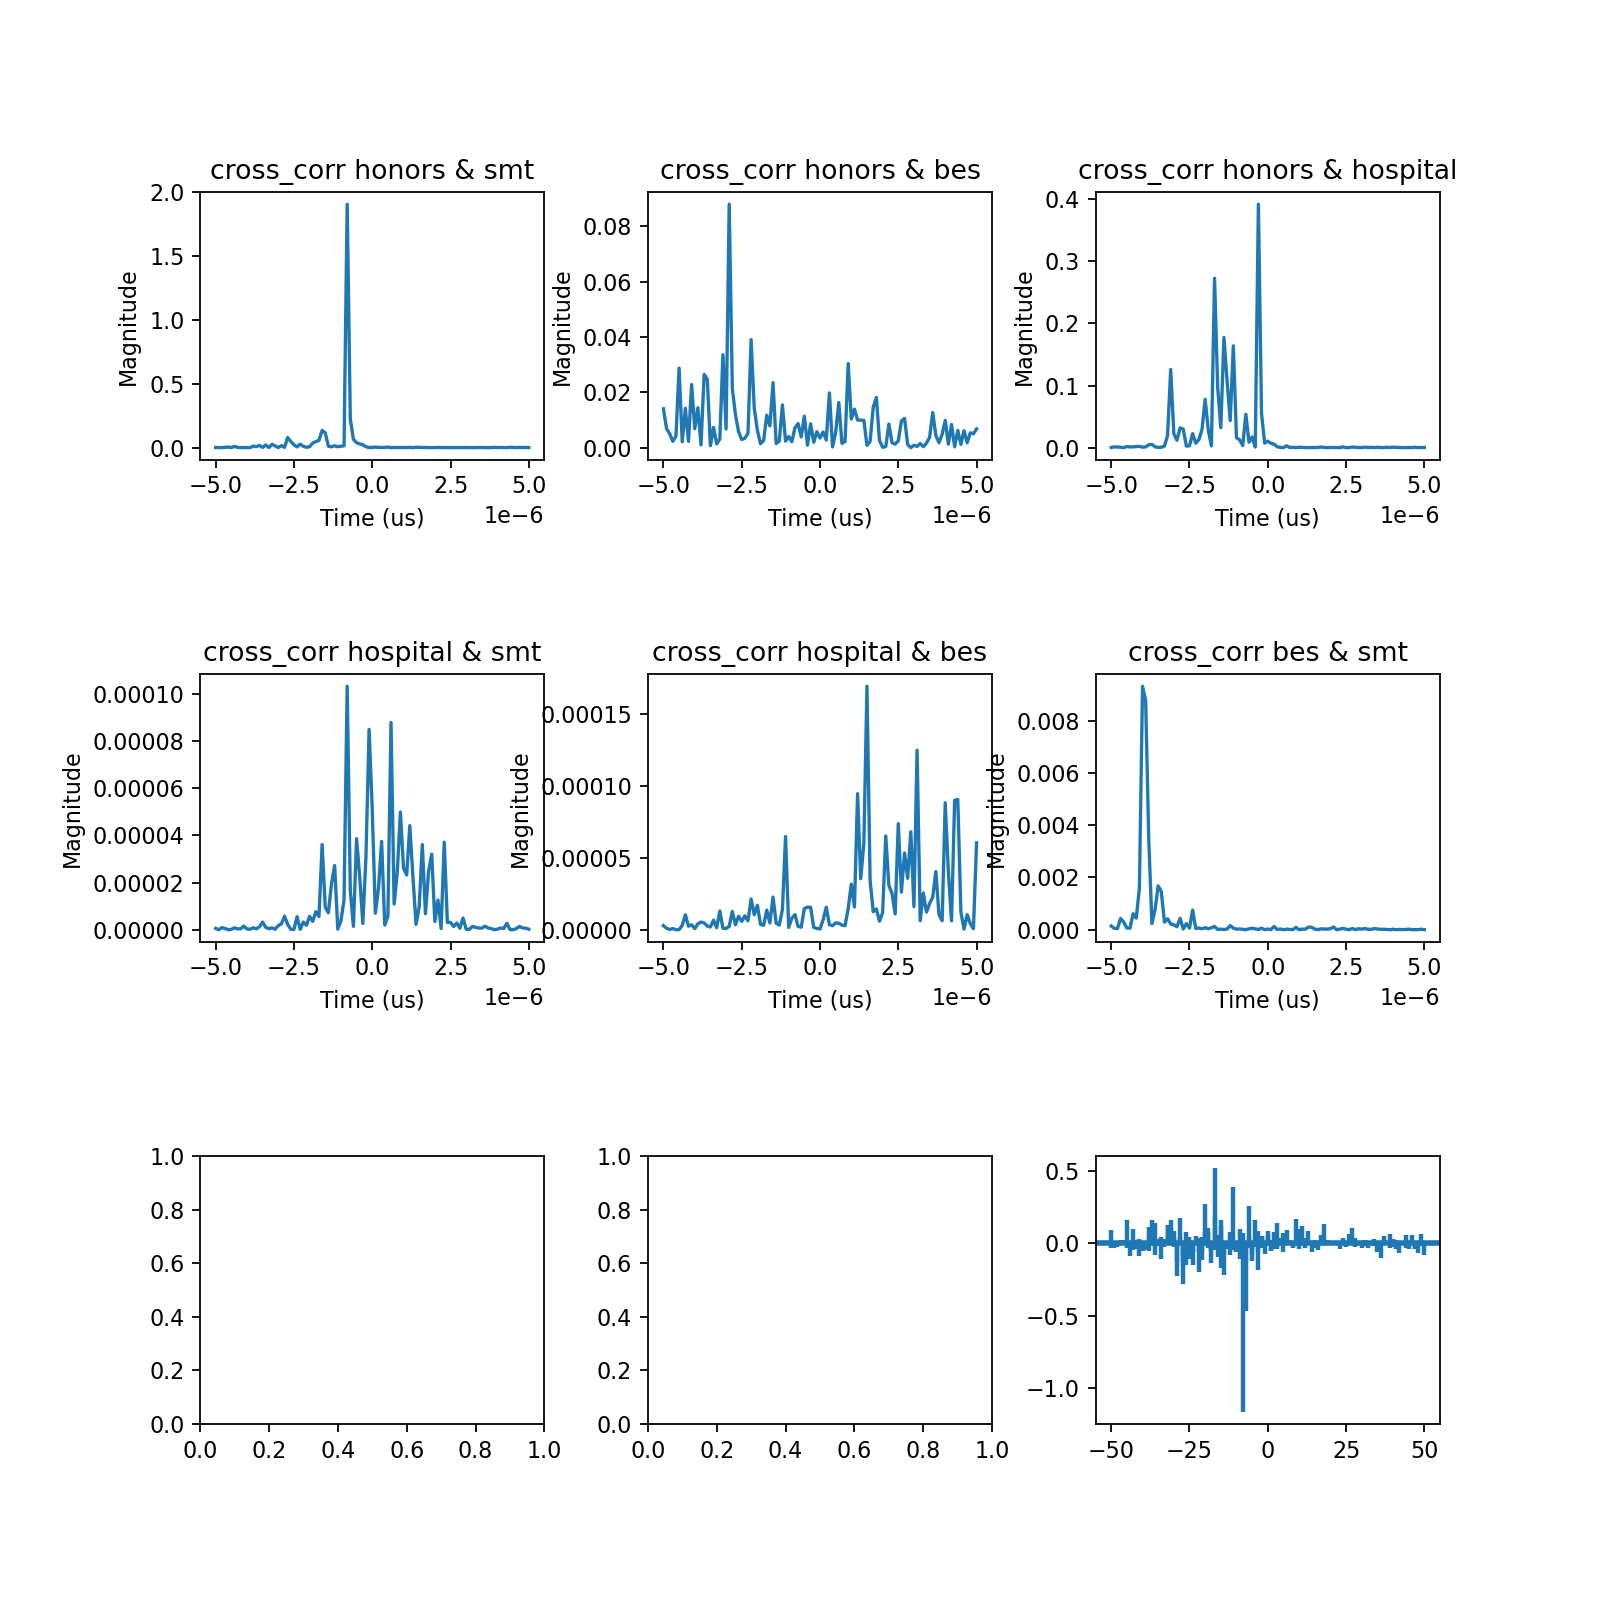

/Users/shivonkuo/opt/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3374: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/Users/shivonkuo/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


TDoA honors - smt = -8e-07 


/Users/shivonkuo/opt/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3374: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/Users/shivonkuo/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


TDoA honors - bes = -2.8999999999999998e-06 


/Users/shivonkuo/opt/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3374: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/Users/shivonkuo/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


TDoA honors - hospital = -3e-07 


/Users/shivonkuo/opt/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3374: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/Users/shivonkuo/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


TDoA hospital - smt = -8e-07 


/Users/shivonkuo/opt/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3374: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/Users/shivonkuo/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


TDoA hospital - bes = 1.5e-06 


/Users/shivonkuo/opt/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3374: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/Users/shivonkuo/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


TDoA bes - smt = -4e-06 


In [42]:
TD = []
fig, axs = plt.subplots(fig_row,fig_col+1, figsize=(10,10))
fig.subplots_adjust(hspace =0.8, wspace=0.3)
f = 0
g = 0
for i in range(node_n):
    for j in range(node_n-i+1):
        raw1 = nodes[i]
        if i == node_n-1-j:
            break
        raw2 = nodes[node_n-1-j]
        xc = plt.xcorr(raw1, raw2, maxlags=50 ,usevlines=True,  normed=False, lw=2) 
        # maxlags should be set to resonable range. When transfer to time, 
        # it shouldn't be way larger than the longest distance between your receivers devided by speed of light.
        
        lags = xc[0]*(1/Fs) #sec
        C = xc[1]
        C = complexToMagS(C)

        mp = np.argmax(C)
        td = lags[mp] #sec

        TD.append(td)
        axs[f,g].plot(lags, C)
        axs[f,g].set_title('cross_corr %s & %s' %(nodes_name[i],nodes_name[node_n-1-j]))
        axs[f,g].set_xlabel('Time (us)')
        axs[f,g].set_ylabel('Magnitude')
        g = g + 1
        if g == fig_col+1:
            f = f+1
            g = 0
        plt.savefig('%s_Xcorr.png' %filename)
        plt.show()
        print('TDoA %s - %s = %s ' %(nodes_name[i],nodes_name[node_n-1-j], td))

Set up the receiver nodes location coordinates in variable 'Rx_pos' (use the same order as 'nodes' and 'nodes_name')

In [43]:
C = 299792458*1e-6  #m/us

# All possible receiver/sensor coordinates in UTM 12 T
coords = {
  'USTAR': (428967.36380947224, 4513453.696705444,25),
  'BES': (428569.088758324, 4512608.436204287,40),
  'HONORS': (429360.58836478635, 4512941.066856734,30),
  'SMT': (429850.83027094963, 4513269.134883303,40),
  'HOSPITAL': (429353.28948917426, 4513718.95404056,15)}

#Necessary functions

#given 2 utm points and their heights, calculate distance
def utmDistance(p1,p2):
    distance = sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2+(p1[2]-p2[2])**2)
    return distance

#Define 5 receivers
P0 = coords['HONORS']
P1 = coords['BES']
P2 = coords['HOSPITAL']
P3 = coords['SMT']
P4 = coords['USTAR']

Rx_pos = [P0, P2, P1, P3] # Change to the receivers you are using!

Generate Coordinates for the possible area (Set 'delta_p' to the resolution size you prefer, and 'area_range' to the distance range outside the receivers you prefer )

In [45]:
delta_p = 50 # in meter (resolution size)
area_range = 1000 # in meter (distance range)
personLL = []
personUR = []

# Set up pixel locations as a grid.
minindex        = np.argmin(Rx_pos,axis=0)
maxindex        = np.argmax(Rx_pos,axis=0)
personLL .append(Rx_pos[minindex[0]][0])
personLL .append(Rx_pos[minindex[1]][1])
personUR .append(Rx_pos[maxindex[0]][0])
personUR .append(Rx_pos[maxindex[1]][1])

pixelCoords, xVals, yVals = calcGridPixelCoords(personLL, personUR, delta_p, area_range)

Calculate Squared Error through the coordinates

In [49]:
Z , miniCoor, miniSSE= calcSSE(pixelCoords, Rx_pos, node_n, TD)
Z_reshape = np.reshape(Z,(len(yVals),len(xVals)))
Z_flip = np.flipud(Z_reshape)

Plot the SSE result Grid

<IPython.core.display.Javascript object>


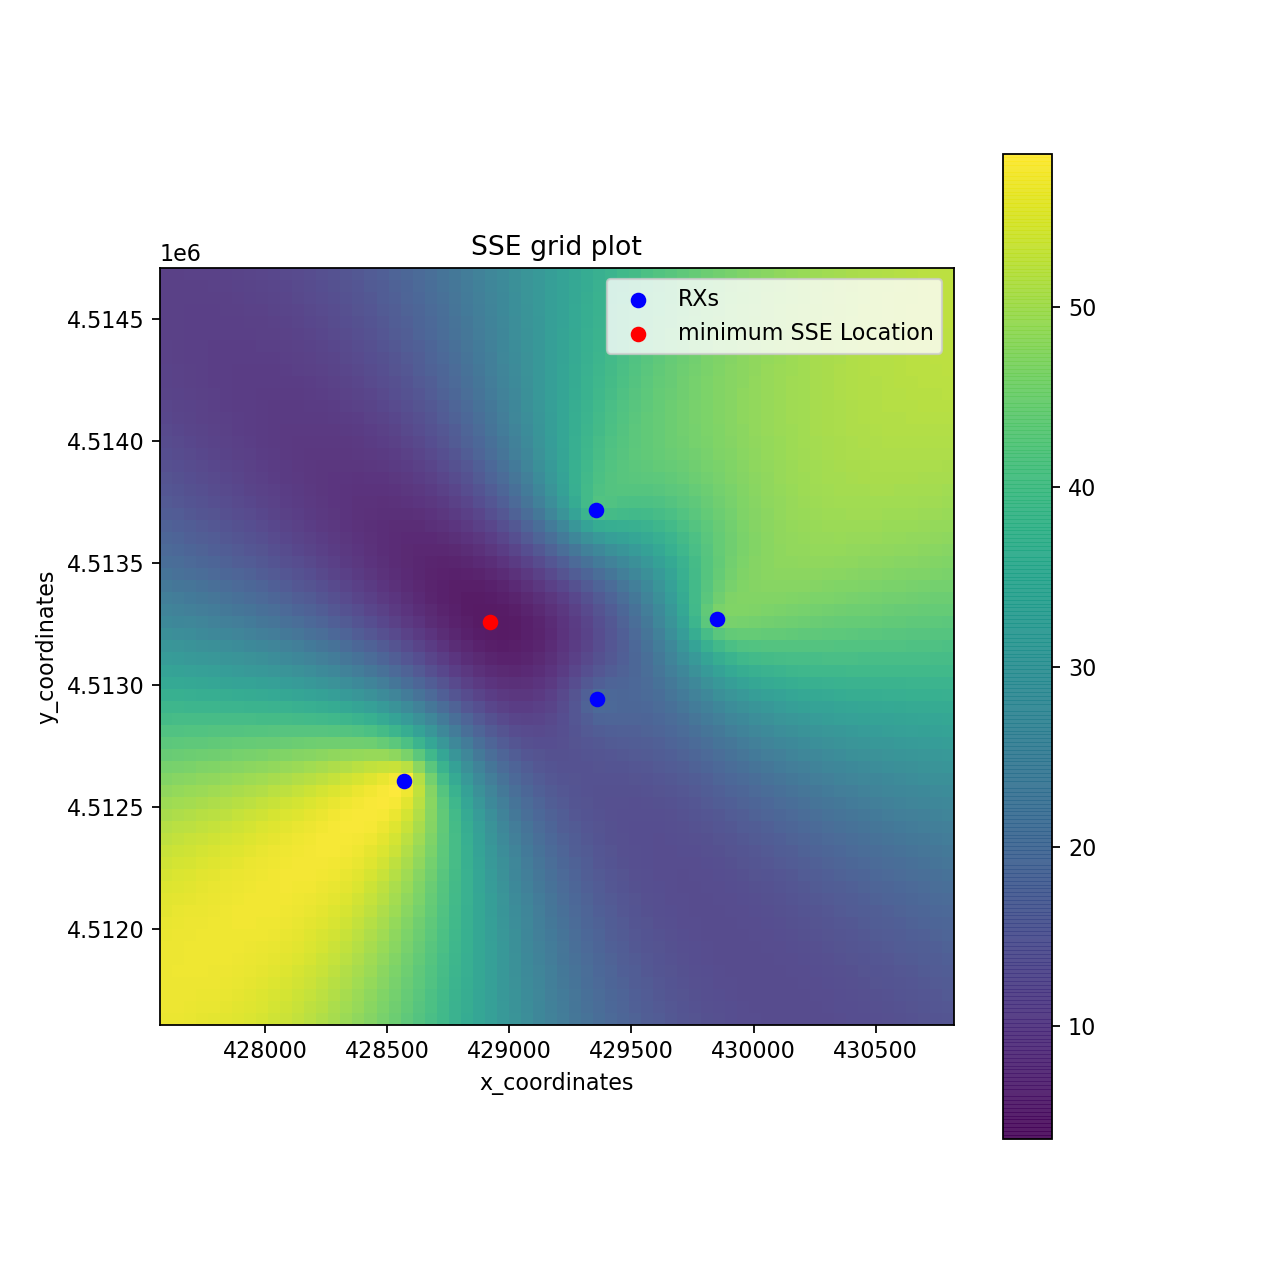

Coordinate [428919.088758324, 4513258.436204287] has the minimum MSE 3.7192060372529983


In [50]:
rx_x = []
rx_y = []
for i in range(len(Rx_pos)):
    rx_x.append(Rx_pos[i][0])
    rx_y.append(Rx_pos[i][1])
    
plt.figure(figsize = (8,8))
im = plt.imshow(Z_flip,  cmap=plt.cm.viridis, alpha=.9, extent=[xVals[0],xVals[-1],yVals[0],yVals[-1]])
plt.scatter(rx_x, rx_y, color ='b',label='RXs')
plt.scatter(miniCoor[0],miniCoor[1],color='r', label='minimum SSE Location')
plt.colorbar(im)
plt.title('SSE grid plot')
plt.xlabel('x_coordinates')
plt.ylabel('y_coordinates')
plt.legend()
plt.show()
print('Coordinate', miniCoor, 'has the minimum MSE', miniSSE)

Plug in the coordinate in the following website to convert into latitude and lontitude, so you can search the location on google map.
https://www.engineeringtoolbox.com/utm-latitude-longitude-d_1370.html
